# Inverted Pendulum using DQN

When moving on from discrete environments, such as grid world or black jack, the amount of state in a continous environment renders traditional tabular methods (Monte Carlo and TD learning) intractable (at least without any modification to the problem formulation). DQN method addresses this problem by using a value function approximator, essentially replacing the Q-table of explicit state-action value with a parameterized function $q^\pi_{\vec w}(s,a,\vec w)$. The vector $\vec w$ stores the weights or parameters of this approximating function.

The motivation of using value function approximator is clear, but where does it fit into the RL picture?
- Value function approximator is a direct mapping between the states (features) to the state-action value $Q(s,\cdot)$ 
- As such, the approximator function fits in the policy evaluation step of the RL training process. We train this function by minimizing the loss between the approximated value function and the actual value function $ s.t. \enspace q^\pi_{\vec w}(s,a,\vec w) \approx q^*$
- However, the true action value function $q^*$ is unknown and must be learnt from the interaction between the agent and its environment. We must employ Q-learning to approximate the true action value function, toward which we will update the parameterized value function $q^\pi_{\vec w}(s,a,\vec w)$. The update is as follow

**The DQN algorithm**
1. From a state $s$, take action $a$ using $\epsilon$-greedy policy, observe the reward $r$ and next state $s'$
2. Store the transition tuple $(s, a, r, s')$ in a replay memory $\mathcal{D}$. This replay memory is a buffer that stores the most recent transition tuples
3. From this replay memory, sample batches of $(s_t, a_t, r_{t+1}, s_{t+1})$ randomly for training the Q-function approximator
4. Adjust the parameters $\vec w$ by optimizing the mean squared error (MSE) between the Q network and the Q-learning target using Q-learning
$$ \mathcal{L}_i (\vec w_i) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}} \bigg[ \Big(r + \gamma \max_{a'}Q(s',a',\vec w^-_i) - Q(s,a,\vec w_i) \Big)^2\bigg]$$ 

When applying stochastic gradient descent, the update at every step is reduced as follows (the math found in the GoodNote notebook):

$$\Delta \vec w = \alpha \Big(r + \gamma \max_{a'} \underbrace{Q(s', a', \vec{w}_i^-)}_{\text{target}} - \underbrace{Q(s,a,\vec w_i)}_{\text{behaviour}} \Big) \vec x(s,a)$$


**Notes:** 

There are two mechanisms introduced in this paper that allow for stable training, one is experience replay, and the other is training two separate methods.
- **Experience replay** - this decorrelates the experience tuples (s,a,r,s') thus follow the i.i.d assumption for training a neural network
- **Two Q-networks**, a target network and a behaviour network. The parameters $\vec w'$ of the target network $Q(s,a,\vec w')$ are only updated infrequently to maintain a stable target. The parameters $\vec w$ of the behaviour network $Q(s,a,\vec w)$ are updated every policy improvement iteration to move toward this target network. The frequency of updating the target network is annother hyperparameter to tune. 


## Question to self
1. What does it mean to apply stochastic gradient descent to simplify the loss function? What are the implications?
- Every policy evaluation iteration, a random sample, or batch of samples, is used for updating the state-action value instead of every single experience stored in the replay buffer. Recall that the random sampling from the replay buffer de-correlates the experience and enforces the i.i.d. assumption
- SGD is used on a small batch of sample to reduce the variance inherent in the different experience in the replay buffer. Despite the noise and bias of this method, the performance of the Q networks improves.


</br>

2. Would it be beneficial to formulate the Q network such that the input is the state vector and the outputs are the Q-values associated with each possible action from the state. As such, one can just take the max value from the target Q network and index into the behaviour network for the corresponding action a?
- That is the common approach for approximating the action value function, outputting Q(s) for all a, then grabbing the maximum value
 
</br>

3. At first do I have to run the agent several times using the initial $\epsilon$-greedy policy to fill the memory buffer with training samples?
- Yes, and then pop in new experience at the end, push the oldest experience in the replay buffer out.

</br>

4. How often does the behaviour target network updated?

- At every step in an episode of the training process, the behaviour network is used for two different purposes:
    - Firstly, the behaviour network governs the trajectory of the agent at every step. 
    - Secondly, the behaviour Q network is used to predict (or infer) the action value for the <s,a> pairs drawn from a batch of experience (s,a,r,s'). These value is compared to the discounted maximum action value at state s', $\max Q(s',\cdot)$, according to the **target network**. 

- The behaviour network prediction of $Q(s,a)$ and the target network's label output of $r+\gamma \max Q(s',a')$ are used to compute a loss function. The gradient of this loss function is used for adjusting the parameters of the behaviour network.
- After the agent has taken a number of step, the parameters (or weights) or the behaviour network is loaded onto the target network.

</br>

5. How can I scale this environment up to have continuous action instead of just left/right?
- To my understanding, actuating the cart to the left or right at similar output level (voltage) at instantaneous moments throughout the control process is good enough for modulating the speed of the cart. Think of PWMs where the voltage is just switch at a certain duty cycle to simulate different voltage level.
- It is possible to have continuous action space. Since the Q network output is the state-action value Q(s,a) at each state s and action a, we know how good each action is in a state. The Q values can then be transformed into a proportional constant to control how much to move left or right (instead of just a binary left/right). This essentially means that the Q-value output of this network is not simply used for selecting the maximizing action at each state but also for governing the magnitude of cart actuation.


In [1]:
import random                       # To draw a random batch of samples form the replay buffer
import gymnasium as gym
import torch
from torch import nn
import torch.optim as optim
import numpy as np

from collections import deque       # replay buffer is a double ended queue that allows elements to be added either to the end or the start

In [2]:
# Simulate several episodes of the cart pole environment (random policy on a human render mode)
env = gym.make("CartPole-v1", render_mode = "human")

state, _ = env.reset(); t = 1
for i in range(100):
    action = env.action_space.sample()
    next_state, reward, term, trunc, info = env.step(action)
    print(f"Time {t:2d}  |  s_t {state}  |  a_t {action:2d}  |  s_t+1 {next_state}  |  reward {reward:.2f}  |  terminated {term:2}  |  {info}")
    state = next_state; t += 1
    if term or trunc:
        break

Time  1  |  s_t [-0.03014127 -0.00404608  0.03193229  0.01581872]  |  a_t  1  |  s_t+1 [-0.03022219  0.19060372  0.03224866 -0.26662064]  |  reward 1.00  |  terminated  0  |  {}
Time  2  |  s_t [-0.03022219  0.19060372  0.03224866 -0.26662064]  |  a_t  1  |  s_t+1 [-0.02641012  0.38525093  0.02691625 -0.54896015]  |  reward 1.00  |  terminated  0  |  {}
Time  3  |  s_t [-0.02641012  0.38525093  0.02691625 -0.54896015]  |  a_t  1  |  s_t+1 [-0.0187051   0.57998466  0.01593705 -0.8330425 ]  |  reward 1.00  |  terminated  0  |  {}
Time  4  |  s_t [-0.0187051   0.57998466  0.01593705 -0.8330425 ]  |  a_t  1  |  s_t+1 [-7.1054040e-03  7.7488524e-01 -7.2380347e-04 -1.1206710e+00]  |  reward 1.00  |  terminated  0  |  {}
Time  5  |  s_t [-7.1054040e-03  7.7488524e-01 -7.2380347e-04 -1.1206710e+00]  |  a_t  1  |  s_t+1 [ 0.0083923   0.97001666 -0.02313722 -1.4135809 ]  |  reward 1.00  |  terminated  0  |  {}
Time  6  |  s_t [ 0.0083923   0.97001666 -0.02313722 -1.4135809 ]  |  a_t  0  |  s_t+1

In [3]:
# Constant definitions
LR = 1e-3
BUFFER_SIZE = 5000                  # size of the experience replay buffer
MIN_REPLAY_SIZE = 1000              # The number of experience to sample before starting training
TARGET_UPDATE_FREQ = 1000           # the number of steps before updating the target network

GAMMA = 0.95                        # Discount factor for return calculation
EPSILON_START = 1.0                 # exploration rate in stochastic policy
EPSILON_END = 0.1                   # minimum exploration rate at the end of decay
EPSILON_DECAY = 5000                # epsilon decay rate

EPISODE_TRAIN = 5000              # number of episodes to train the Q-network
BATCH_SIZE = 32

In [4]:
# Define Q-network architecture
class QNetwork(nn.Module):
    ''' A QNetwork class that initialize an MLP neural Q network with two hidden layers, each with 128 nodes '''
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)                       # The regression output are the state values of Q(s,a=left) and Q(s,a=right)

In [5]:
# Initialize the environment and the Q network

env = gym.make("CartPole-v1")
state_space = env.observation_space.shape[0]        # State space of cart pos & vel, and pendulum angular pos and vel. Each component is a continuous value
action_space =  env.action_space.n                   # Action space of left or right

q_network = QNetwork(state_space,action_space)
target_network = QNetwork(state_space,action_space)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()                               # target network is only used for evaluation/inference and not trained

optimizer = optim.SGD(q_network.parameters(), lr = LR)
replay_buffer = deque(maxlen=BUFFER_SIZE)

QNetwork(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [47]:
# Fill replay buffer with some initial samples for training (random policy)
obs, _ = env.reset()
for _ in range(MIN_REPLAY_SIZE):
    action = env.action_space.sample()
    next_obs, reward, term, trunc, _ = env.step(action)
    done = term or trunc

    replay_buffer.append((obs, action, reward, next_obs, done))
    obs = next_obs if not done else env.reset()[0]

In [48]:
# Training loop
reward_history = np.zeros(EPISODE_TRAIN)
epsilon = EPSILON_START
step_count = 0
target_network_update_count = 0

for episode in range(EPISODE_TRAIN):
    obs, _ = env.reset()
    eps_rewards = 0
    

    while True:
        # Epsilon-greedy policy to select action
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():       # Doing inference so no need to track operations
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)  # unsqueeze to fake the sample (batch) dimension
                q_values = q_network(state_tensor)
                action = q_values.argmax().item()                   # index of the maximum output (action)
        
        # Interact with the environment
        next_obs, reward, term, trunc, _ = env.step(action)
        done = term or trunc
        replay_buffer.append((obs, action, reward, next_obs, done))
        obs = next_obs
        eps_rewards += reward
        step_count += 1

        # Sample a batch and update the network
        if len(replay_buffer) >= BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(states)                      # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
            actions = torch.LongTensor(actions).unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Compute targets using target network Q(s',a',w_i^-)
            with torch.no_grad():
                target_q_values = target_network(next_states)       # Find a batch of Q(s',a',w_i^-) from the batch of next_states
                max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                targets = rewards + GAMMA * max_target_q_values * (1 - dones)       # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states

            # Compute the current Q values for the actions taken Q(s,a,w_i)
            q_values = q_network(states).gather(1, actions)         # obtain the q_values associated to the actual action taken in each sample

            # Update the parameters of the behaviour q_network
            ## Strategy 1 - Compute the loss and update the q_network toward the target greedy network
            loss = nn.MSELoss()(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

            ## Strategy 2 - Use Q-learning to update the weights manually

             # Periodically update the target network by loading the weights from the behavior network
            if step_count % TARGET_UPDATE_FREQ == 0:
                target_network_update_count += 1
                target_network.load_state_dict(q_network.state_dict())

        if done:
            break
    
   
    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon - (EPSILON_START - EPSILON_END)/EPSILON_DECAY)

    reward_history[episode] = eps_rewards
    print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
    print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

env.close()

Episode     0: Total reward =  33.0, Epsilon = 1.000, Step count =    33, Target update count =   0
Average reward 0.00
Episode     1: Total reward =  20.0, Epsilon = 1.000, Step count =    53, Target update count =   0
Average reward 16.50
Episode     2: Total reward =  13.0, Epsilon = 0.999, Step count =    66, Target update count =   0
Average reward 17.67
Episode     3: Total reward =  59.0, Epsilon = 0.999, Step count =   125, Target update count =   0
Average reward 16.50
Episode     4: Total reward =  20.0, Epsilon = 0.999, Step count =   145, Target update count =   0
Average reward 25.00
Episode     5: Total reward =  26.0, Epsilon = 0.999, Step count =   171, Target update count =   0
Average reward 24.17
Episode     6: Total reward =  17.0, Epsilon = 0.999, Step count =   188, Target update count =   0
Average reward 24.43
Episode     7: Total reward =  12.0, Epsilon = 0.999, Step count =   200, Target update count =   0
Average reward 23.50
Episode     8: Total reward =  25

In [35]:
def EMA_filter(reward: list, alpha):
    output = np.zeros(len(reward)+1)
    output[0] = reward[0]
    for idx, item in enumerate(reward):
        output[idx+1] = (1 - alpha) * output[idx] + alpha * item
    
    return output

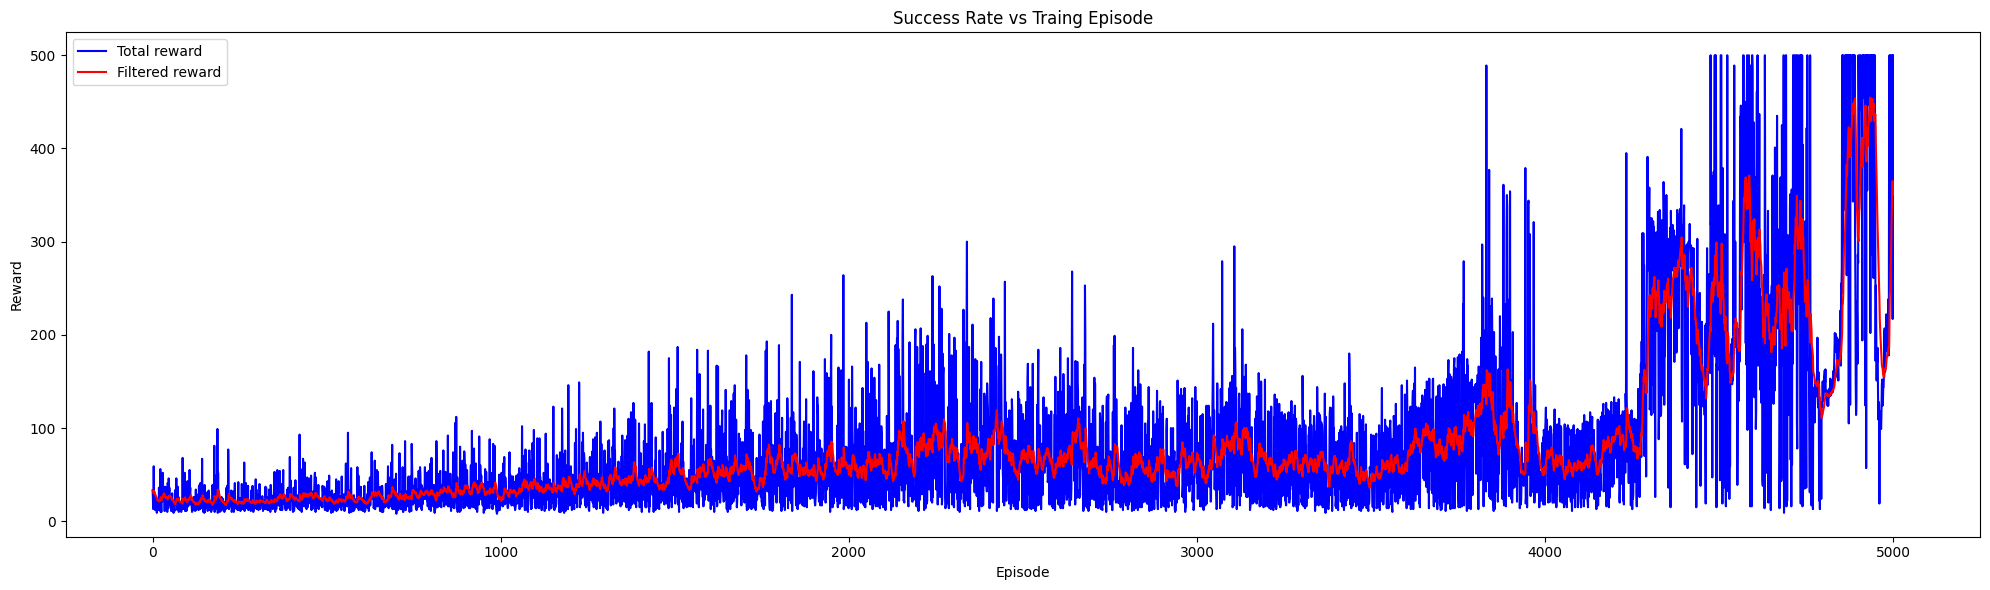

In [49]:
# Visualize the history of success rate
import matplotlib.pyplot as plt

episode = range(EPISODE_TRAIN)
filtered_reward_history = EMA_filter(reward_history, 0.1)

# Set figure size (width, height) in inches
plt.figure(figsize=(20, 6))

slice_idx = len(reward_history)
# Plot y1 vs x on the first subplot
plt.plot(episode[:slice_idx], reward_history[:slice_idx], color = "blue")
plt.plot(episode[:slice_idx], filtered_reward_history[:slice_idx], color = "red")
plt.title('Success Rate vs Traing Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['Total reward', 'Filtered reward'])

# Adjust layout
plt.tight_layout()
plt.show()

# Save the trained model

In [55]:
import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run

# Generate a timestamped directory for the training run
timestamp = datetime.now().strftime("%y%m%d_%H%M%S")
BASE_DIR = os.getcwd()
OUTPUT_DIR = os.path.join(BASE_DIR,f"inv_pend_results/{timestamp}_{EPISODE_TRAIN}_{BATCH_SIZE}_{LR}_{GAMMA}_{TARGET_UPDATE_FREQ}_{EPSILON_DECAY}")
os.makedirs(OUTPUT_DIR, exist_ok=True)

torch.save({
    'model_state_dict': q_network.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    
    'learning_rate': LR,
    'buffer_size': BUFFER_SIZE,
    'min_replay_size': MIN_REPLAY_SIZE,
    'target_update_freq': TARGET_UPDATE_FREQ,

    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_end': EPSILON_END,
    'epsilon_decay': EPSILON_DECAY,

    'episode_train': EPISODE_TRAIN,
    'batch_size': BATCH_SIZE
}, os.path.join(OUTPUT_DIR,'q_network_checkpoint.pth'))

In [64]:
checkpoint = torch.load("C:/Minh Nguyen/experiment/DRL/gym_exercise/inv_pend_results/250520_165708_5000_32_0.001_0.95_1000_5000/q_network_checkpoint.pth")
q_network_loaded = QNetwork(state_space,action_space)
q_network_loaded.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [78]:
print(checkpoint.keys())
print(checkpoint['optimizer_state_dict'].keys())

dict_keys(['model_state_dict', 'optimizer_state_dict', 'learning_rate', 'buffer_size', 'min_replay_size', 'target_update_freq', 'gamma', 'epsilon_start', 'epsilon_end', 'epsilon_decay', 'episode_train', 'batch_size'])
dict_keys(['state', 'param_groups'])


# Performance Visualization

Visualize the performance of the trained Q network in multiple simulations and observer the reward.

In [ ]:
env_test = gym.make("CartPole-v1", render_mode = "human")

# print(type(obs))
for episode in range(5):
    obs, _ = env_test.reset()
    done = False
    eps_reward = 0

    while not done:
        with torch.no_grad():       # Doing inference so no need to track operations
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)  # unsqueeze to fake the sample (batch) dimension
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()                   # index of the maximum output (action)
        
        next_obs, reward, term, trunc, _ = env_test.step(action)

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

Reward from episode   0 is 500.0
Reward from episode   1 is 500.0
Reward from episode   2 is 500.0
Reward from episode   3 is 500.0
Reward from episode   4 is 500.0


Visualize the state vs time plot

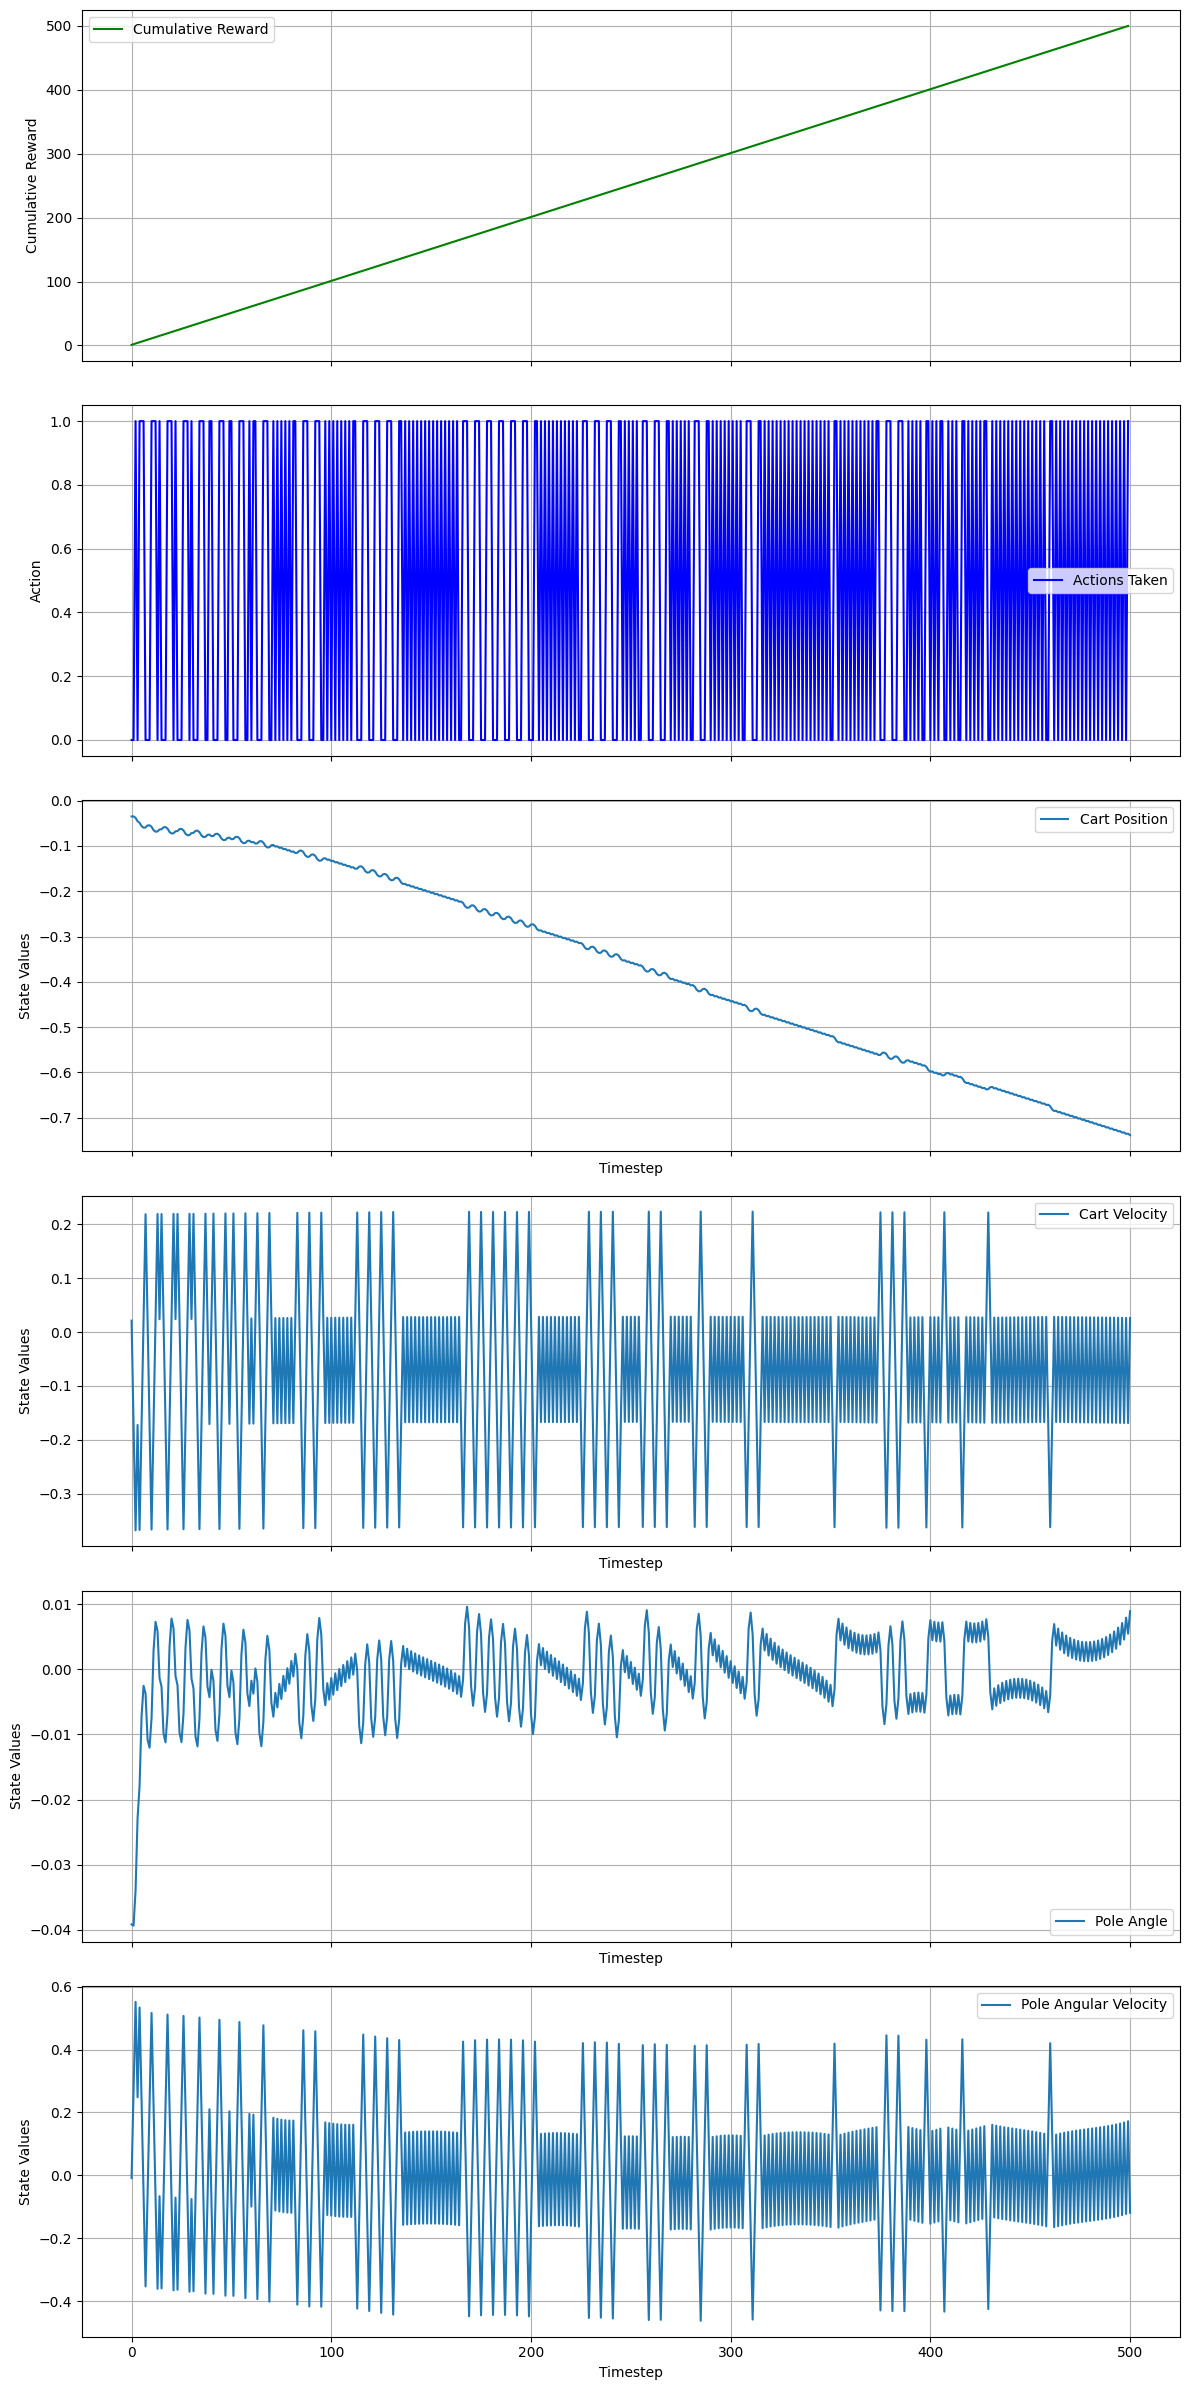

In [103]:
import matplotlib.pyplot as plt

obs, _ = env_test.reset()
done = False
obs_history = []; obs_history.append(obs)
action_history = []
reward_history = []

while not done:
    with torch.no_grad():       # Doing inference so no need to track operations
        state_tensor = torch.FloatTensor(obs).unsqueeze(0)  # unsqueeze to fake the sample (batch) dimension
        q_values = q_network(state_tensor)
        action = q_values.argmax().item()                   # index of the maximum output (action)
    
    next_obs, reward, term, trunc, _ = env_test.step(action)

    action_history.append(action)
    obs_history.append(next_obs)
    
    if not reward_history: reward_history.append(reward)
    else: reward_history.append(reward_history[-1] + reward)

    done = term or trunc
    obs = next_obs

# Convert obs_history to a NumPy array for easier slicing
obs_array = np.array(obs_history)

# Create subplots
fig, axs = plt.subplots(6, 1, figsize=(12, 24), sharex=True)

# 1. Plot cumulative reward history
axs[0].plot(reward_history, label='Cumulative Reward', color='green')
axs[0].set_ylabel('Cumulative Reward')
axs[0].legend()
axs[0].grid(True)

# 2. Plot action history
axs[1].plot(action_history, label='Actions Taken', color='blue')
axs[1].set_ylabel('Action')
axs[1].legend()
axs[1].grid(True)

# 3. Plot each CartPole state variable over time
state_labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
for i in range(4):
    axs[i+2].plot(obs_array[:, i], label=state_labels[i])
    axs[i+2].set_ylabel('State Values')
    axs[i+2].set_xlabel('Timestep')
    axs[i+2].legend()
    axs[i+2].grid(True)

plt.tight_layout()
plt.show()
